# Feature importance analysis

In this notebook we analyse the importance of each SNP to the model using the [Integrated Gradients](https://arxiv.org/pdf/1703.01365.pdf) method. 

_Imports and configs_

In [8]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
import explain_ensemble
# from diabnet.model import load
from diabnet.data import get_feature_names
from diabnet.ensemble import Ensemble
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import numpy as np
import pandas as pd
from pandas.plotting import parallel_coordinates

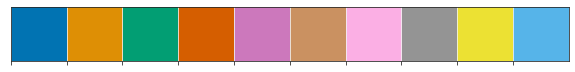

In [10]:
colors = sns.color_palette("colorblind")
sns.palplot(colors)
sns.set_style("whitegrid")
sns.set_style("ticks",{'axes.grid': True,'grid.color': '.95', 'grid.linestyle': '-'})

_load trained ensemble model_

In [11]:
ensemble = Ensemble('../results/models/positive/model-positive-21-adamw-lc7-2021-10-05')

In [12]:
feat_names = get_feature_names("../data/datasets/visits_sp_unique_test_positivo_1000_random_0.csv", use_sex=True, use_parents_diagnosis=True)

In [13]:
# DEBUG:
feat_names[-20:]

['snp_1_28265165',
 'snp_7_62322704',
 'snp_6_57432511',
 'snp_19_5147864',
 'snp_9_1667961',
 'snp_7_142786651',
 'snp_9_68692515',
 'snp_12_53198338',
 'snp_6_37571581',
 'snp_20_52032232',
 'snp_20_52032233',
 'snp_20_26104019',
 'snp_20_50189624',
 'snp_1_143276644',
 'snp_16_9536673',
 'snp_20_25734788',
 'AGE',
 'sex',
 'mo_t2d',
 'fa_t2d']

In [14]:
# feature attribution using training dataset
e_train = explain_ensemble.ExplainModel(ensemble, feat_names, "../data/datasets/visits_sp_unique_train_positivo_1000_random_0.csv")

In [15]:
# feature attribution using test dataset
e_test = explain_ensemble.ExplainModel(ensemble, feat_names, "../data/datasets/visits_sp_unique_test_positivo_1000_random_0.csv")

In [16]:
def feat_importance(values, age, sex):
    imp = values.calc_attr(age, sex)
    # testa se o SNP tem valores 1 ou 2. caso não tenha, sua importancia não pode ser calculada
    s = {k: [np.mean(imp[k]), np.median(imp[k])] for k in imp if len(imp[k]) > 0} 
    df = pd.DataFrame.from_dict(s, orient='index')
    df.rename(columns={0:f'{sex}{age}_mean', 1:f'{sex}{age}_median'}, inplace=True)
    # df.sort_values(by=0, ascending=False).head(50)
    return df
    

# Feature Importance

Qual a importância dos SNPs independentemente de outras características (sexo, diagnóstico dos pais, idade*).
*Para torna independente da idade fixamos a idade em 50.

In [17]:
age = 50
sex = 'X' # 'X' significa qualquer sexo

Não há um consenso se a análise de importância das características (feature importance) deve ser feita com os dados de teste ou treinamento. Nós testamos os dois...

In [18]:
df_feat_imp_50_X_train = feat_importance(e_train, 50, 'X')

In [19]:
df_feat_imp_50_X_test = feat_importance(e_test, 50, 'X')

No entanto, no conjunto de teste 44 dos 1000 SNPs não possuem o gene base do alelo recessivo (valores 1 ou 2) e consequentemente, não conseguimos atribuir um valor de importância. E como notamos pelo boxplot abaixo, boa parte deles podem ser importantes.

44 SNPs não tem valores no conjunto de teste


<AxesSubplot:ylabel='X50_mean'>

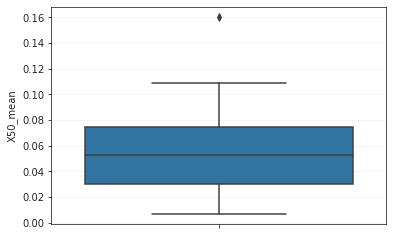

In [20]:
excluded = df_feat_imp_50_X_train[df_feat_imp_50_X_train.index.isin(df_feat_imp_50_X_test.index) == False]
print(f"{excluded.count()[0]} SNPs não tem valores no conjunto de teste")
sns.boxplot(y="X50_mean", data=excluded)

In [21]:
df_feat_imp_50_X = df_feat_imp_50_X_train.join(df_feat_imp_50_X_test, how='inner', lsuffix='_train', rsuffix='_test')
df_feat_imp_50_X['SNP'] = df_feat_imp_50_X.index
# parallel_coordinates(tmp, '1_M50', cols='M50_mean','F50_mean'])
df_feat_imp_50_X = df_feat_imp_50_X.sort_values(by="X50_mean_train")
df_feat_imp_50_X # apenas 956 pq 44 dos SNPs não tem valores 1 ou 2 no conjunto de teste 

,X50_mean_train,X50_median_train,X50_mean_test,X50_median_test,SNP
snp_17_15464147,-0.113946,-0.065501,-0.123370,-0.073535,snp_17_15464147
snp_21_11058226,-0.085580,-0.053485,-0.079665,-0.044171,snp_21_11058226
snp_11_89308032,-0.070583,-0.038380,-0.073120,-0.039042,snp_11_89308032
snp_11_89308027,-0.063661,-0.029908,-0.067564,-0.032192,snp_11_89308027
snp_16_82889990,-0.059832,-0.039546,-0.061936,-0.042707,snp_16_82889990
...,...,...,...,...,...
snp_20_32074430,0.155232,0.096978,0.187379,0.142313,snp_20_32074430
snp_10_15653813,0.165404,0.073248,0.175247,0.082269,snp_10_15653813
snp_8_23479247,0.166457,0.076397,0.100069,0.037462,snp_8_23479247
snp_3_123912059,0.174667,0.094130,0.200042,0.123640,snp_3_123912059


Comparando a média e a mediana da importância calculada para os conjuntos de treinamento e teste podemos ver que há uma correlação significativa (como esperado). Logo, optaremos por realizar as análises subsequentes apenas com a importância calculada no conjunto de treinamento.

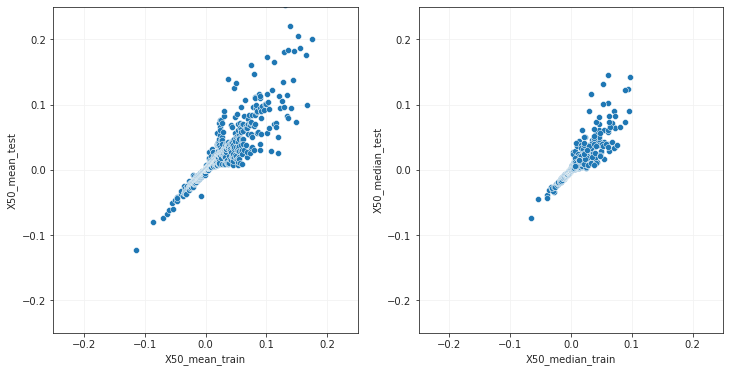

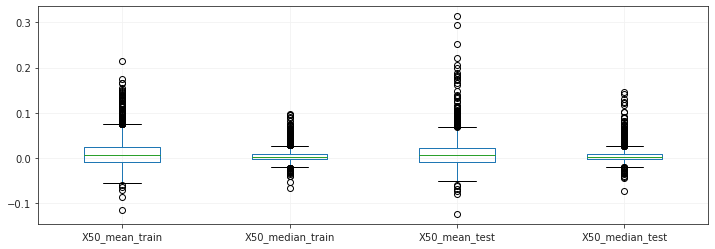

In [22]:
plt.figure(figsize=(12,6));
plt.subplot(121);
# plt.scatter(tmp.X50_mean_train.values, tmp.X50_mean_test.values);
sns.scatterplot(x="X50_mean_train", y="X50_mean_test", data=df_feat_imp_50_X)
plt.ylim(-0.25,0.25)
plt.xlim(-0.25,0.25)
plt.subplot(122);
# plt.scatter(tmp.X50_median_train.values, tmp.X50_median_test.values);
sns.scatterplot(x="X50_median_train", y="X50_median_test", data=df_feat_imp_50_X)
plt.ylim(-0.25,0.25)
plt.xlim(-0.25,0.25)
plt.figure(figsize=(12,4));
df_feat_imp_50_X.boxplot();

<AxesSubplot:ylabel='X50_mean'>

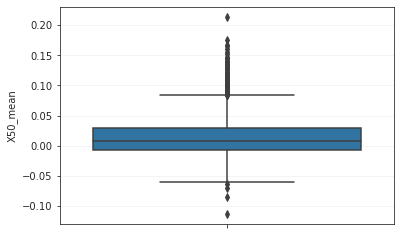

In [23]:
sns.boxplot(y="X50_mean", data=df_feat_imp_50_X_train)

In [24]:
df_feat_imp_50_X_train.describe()

,X50_mean,X50_median
count,1000.000000,1000.000000
mean,0.016810,0.006433
std,0.036635,0.017728
min,-0.113946,-0.065501
25%,-0.006680,-0.002235
50%,0.008420,0.002412
75%,0.029477,0.010486
max,0.213830,0.096978


In [25]:
df_feat_imp_50_X_train["chr"] = [int(s.split('_')[1]) for s in df_feat_imp_50_X_train.index]
df_feat_imp_50_X_train["pos"] = [float(s.split('_')[2]) for s in df_feat_imp_50_X_train.index]
df_feat_imp_50_X_train

,X50_mean,X50_median,chr,pos
snp_8_133462953,0.019887,0.004876,8,133462953.0
snp_2_91635413,0.008880,0.002931,2,91635413.0
snp_9_25963828,0.014951,0.008261,9,25963828.0
snp_1_17764169,0.018678,0.007793,1,17764169.0
snp_12_41767967,-0.002817,-0.000888,12,41767967.0
...,...,...,...,...
snp_20_26104019,0.020460,0.010976,20,26104019.0
snp_20_50189624,-0.009402,-0.005578,20,50189624.0
snp_1_143276644,-0.001233,-0.000246,1,143276644.0
snp_16_9536673,0.004944,0.000679,16,9536673.0


In [26]:
df_feat_imp_50_X_train

,X50_mean,X50_median,chr,pos
snp_8_133462953,0.019887,0.004876,8,133462953.0
snp_2_91635413,0.008880,0.002931,2,91635413.0
snp_9_25963828,0.014951,0.008261,9,25963828.0
snp_1_17764169,0.018678,0.007793,1,17764169.0
snp_12_41767967,-0.002817,-0.000888,12,41767967.0
...,...,...,...,...
snp_20_26104019,0.020460,0.010976,20,26104019.0
snp_20_50189624,-0.009402,-0.005578,20,50189624.0
snp_1_143276644,-0.001233,-0.000246,1,143276644.0
snp_16_9536673,0.004944,0.000679,16,9536673.0


In [27]:
df_dataset_train = pd.read_csv("../data/datasets/visits_sp_unique_train_positivo_1000_random_0.csv")

In [28]:
[np.mean(df_dataset_train[i])/2 for i in df_feat_imp_50_X_train.index]

[0.0008370535714285714,
 0.07672991071428571,
 0.08872767857142858,
 0.05970982142857143,
 0.03627232142857143,
 0.24274553571428573,
 0.07756696428571429,
 0.04938616071428571,
 0.0013950892857142857,
 0.056919642857142856,
 0.046595982142857144,
 0.005301339285714286,
 0.10044642857142858,
 0.07059151785714286,
 0.123046875,
 0.007254464285714286,
 0.4408482142857143,
 0.04938616071428571,
 0.06947544642857142,
 0.06501116071428571,
 0.002232142857142857,
 0.06501116071428571,
 0.0030691964285714285,
 0.07310267857142858,
 0.064453125,
 0.0027901785714285715,
 0.12416294642857142,
 0.0008370535714285714,
 0.0030691964285714285,
 0.006138392857142857,
 0.060825892857142856,
 0.017857142857142856,
 0.0027901785714285715,
 0.09933035714285714,
 0.002232142857142857,
 0.46902901785714285,
 0.07979910714285714,
 0.10072544642857142,
 0.08203125,
 0.010881696428571428,
 0.04241071428571429,
 0.08147321428571429,
 0.0027901785714285715,
 0.12751116071428573,
 0.06780133928571429,
 0.1012834

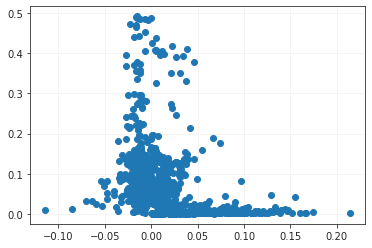

In [29]:
plt.scatter(df_feat_imp_50_X_train["X50_mean"],[np.mean(df_dataset_train[i])/2 for i in df_feat_imp_50_X_train.index])

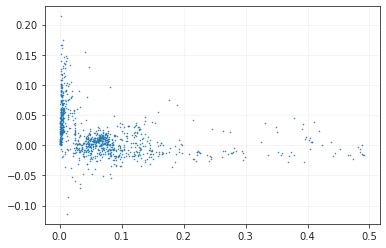

In [30]:
plt.scatter([np.mean(df_dataset_train[i])/2 for i in df_feat_imp_50_X_train.index], df_feat_imp_50_X_train["X50_mean"], marker='.', s=1)

O gráfico da atribuição dos SNPs separado por cromossomo (abaixo) mostra que os chr 1 e 3 

<AxesSubplot:xlabel='chr', ylabel='X50_mean'>

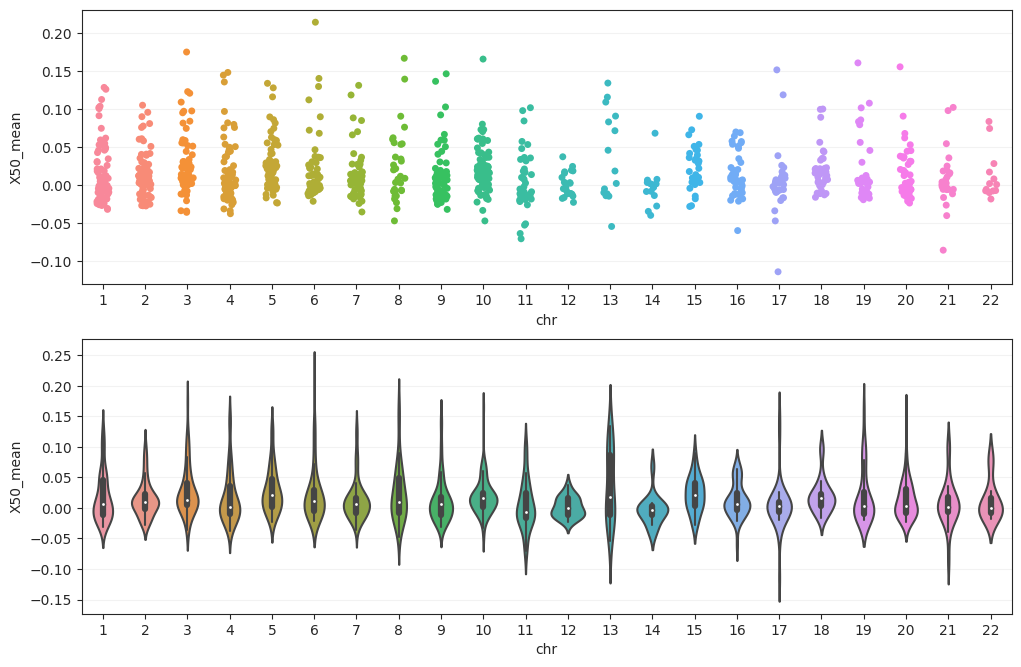

In [31]:
fig = plt.figure(figsize=(12,8), dpi=100)
plt.subplot(211)
sns.stripplot(x="chr", y="X50_mean", data=df_feat_imp_50_X_train, jitter=0.15)
plt.subplot(212)
sns.violinplot(x="chr", y="X50_mean", data=df_feat_imp_50_X_train, whis=np.inf)

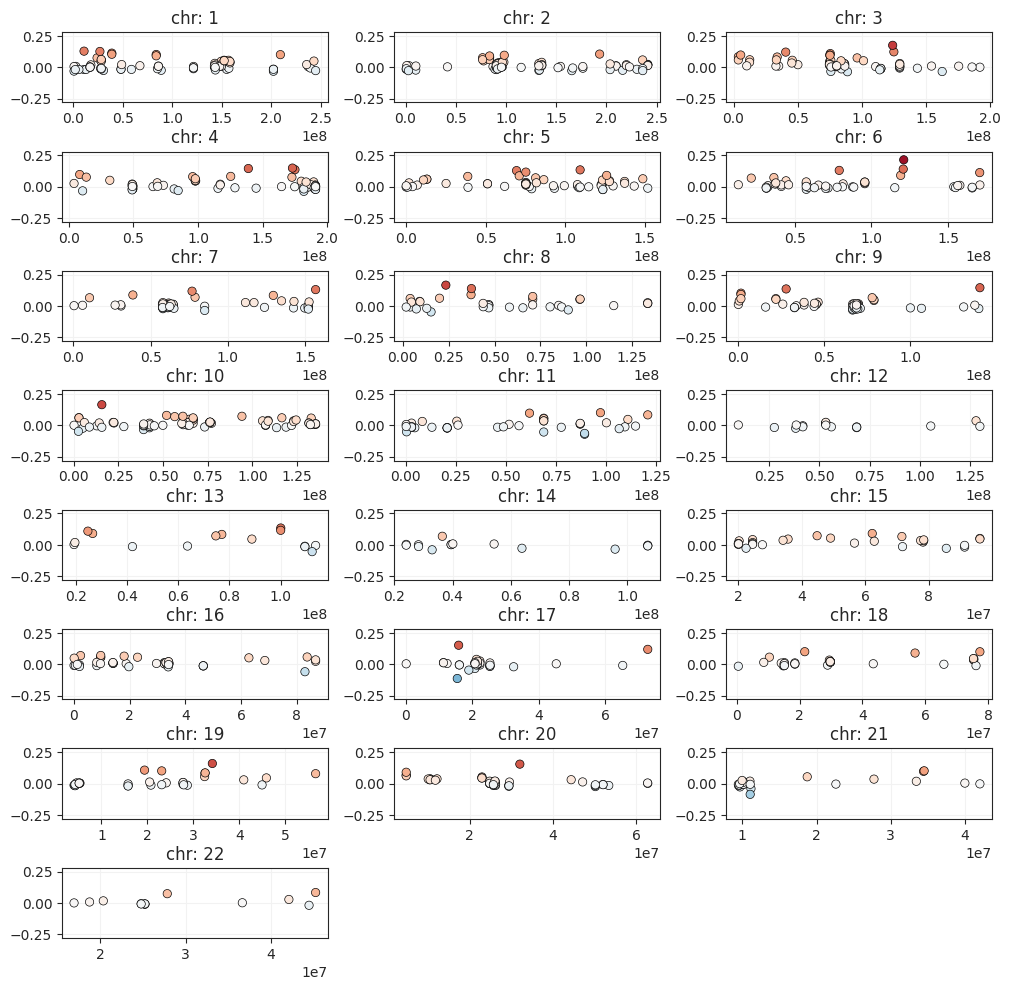

In [32]:
fig = plt.figure(figsize=(12,12), dpi=100)
plt.subplots_adjust(hspace=0.7, wspace=0.25)
for i in range(22):
    ax1=plt.subplot(8, 3, i+1)
    plt.title(f"chr: {i+1}")
    sns.scatterplot(x='pos', 
                    y="X50_mean", 
                    data=df_feat_imp_50_X_train[df_feat_imp_50_X_train["chr"]==i+1], 
                    hue="X50_mean", 
                    hue_norm=(-0.25,0.25), palette="RdBu_r", edgecolor="k")
    ax1.get_legend().remove()
    plt.ylim(-0.28,0.28)
    plt.ylabel("")
    plt.xlabel("")


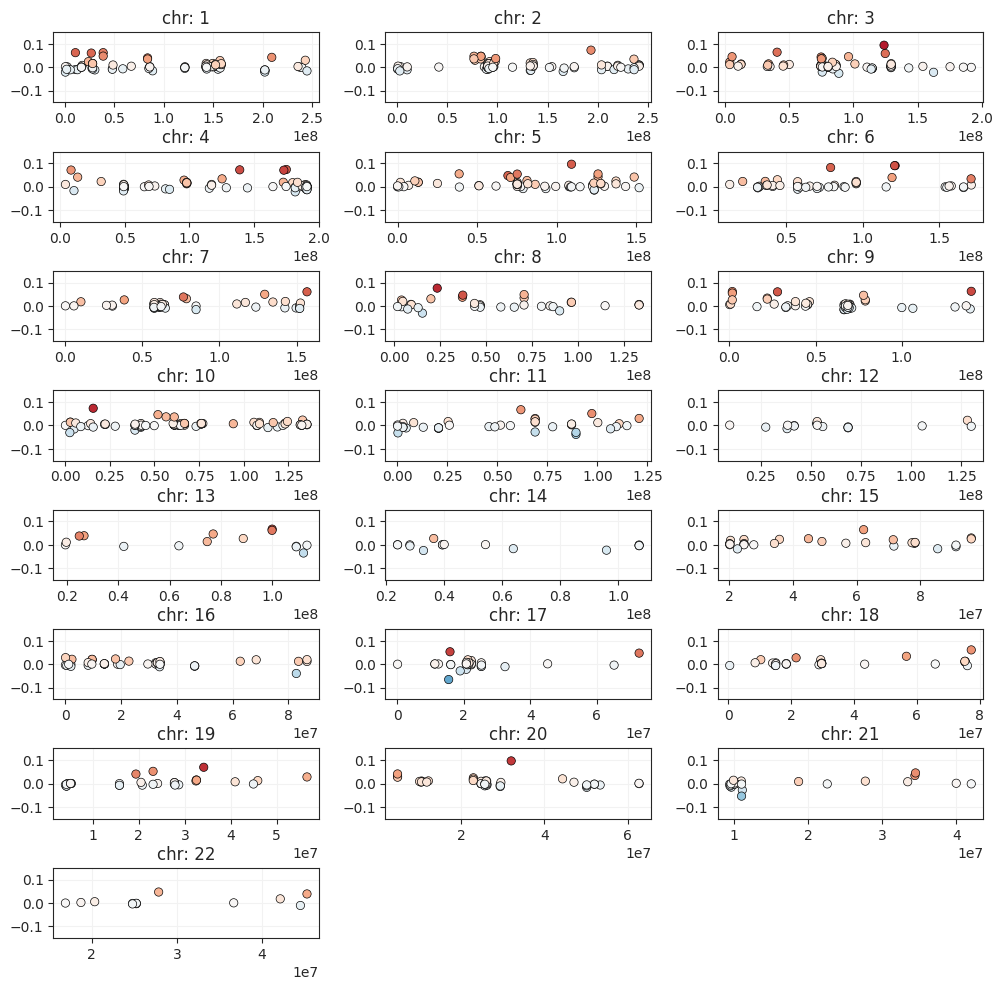

In [33]:
fig = plt.figure(figsize=(12,12), dpi=100)
plt.subplots_adjust(hspace=0.7, wspace=0.25)
for i in range(22):
    ax1=plt.subplot(8, 3, i+1)
    plt.title(f"chr: {i+1}")
    sns.scatterplot(x='pos', y="X50_median", data=df_feat_imp_50_X_train[df_feat_imp_50_X_train["chr"]==i+1], hue="X50_mean", hue_norm=(-0.22,0.22), palette="RdBu_r", edgecolor="k")
    ax1.get_legend().remove()
    plt.ylim(-0.15,0.15)
    plt.ylabel("")
    plt.xlabel("")

In [34]:
selection = df_feat_imp_50_X_train[abs(df_feat_imp_50_X_train['X50_mean'])> 2*df_feat_imp_50_X_train['X50_mean'].std()]

In [35]:
# selection.sort_values(by='X50_mean').to_csv("feature_importance.csv")

In [36]:
selection.sort_values(by='X50_mean', ascending=False)

,X50_mean,X50_median,chr,pos
snp_6_121073528,0.213830,0.089722,6,121073528.0
snp_3_123912059,0.174667,0.094130,3,123912059.0
snp_8_23479247,0.166457,0.076397,8,23479247.0
snp_10_15653813,0.165404,0.073248,10,15653813.0
snp_19_34109339,0.160385,0.069746,19,34109339.0
...,...,...,...,...
snp_1_24057357,0.074490,0.023885,1,24057357.0
snp_3_96250606,0.074379,0.045157,3,96250606.0
snp_22_27854694,0.074244,0.046839,22,27854694.0
snp_21_11058226,-0.085580,-0.053485,21,11058226.0


In [37]:
selection_median = df_feat_imp_50_X_train[abs(df_feat_imp_50_X_train['X50_median'])> 2*df_feat_imp_50_X_train['X50_median'].std()]

In [38]:
selection_median.sort_values(by='X50_median', ascending=False)

,X50_mean,X50_median,chr,pos
snp_20_32074430,0.155232,0.096978,20,32074430.0
snp_5_109351989,0.133547,0.095678,5,109351989.0
snp_3_123912059,0.174667,0.094130,3,123912059.0
snp_6_121073528,0.213830,0.089722,6,121073528.0
snp_6_120756365,0.140002,0.089557,6,120756365.0
...,...,...,...,...
snp_2_76699249,0.060121,0.035654,2,76699249.0
snp_11_89308032,-0.070583,-0.038380,11,89308032.0
snp_16_82889990,-0.059832,-0.039546,16,82889990.0
snp_21_11058226,-0.085580,-0.053485,21,11058226.0


<AxesSubplot:xlabel='chr', ylabel='count'>

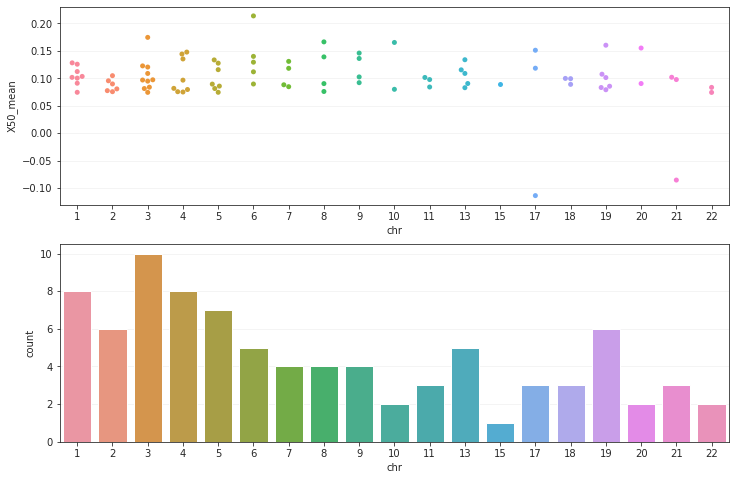

In [39]:
fig = plt.figure(figsize=(12,8))
plt.subplot(211)
# sns.stripplot(x="chr", y="X50_mean", data=selection, jitter=0.15)
sns.swarmplot(x="chr", y="X50_mean", data=selection)
plt.subplot(212)
# sns.barplot(x="chr", y="X50_mean", data=selection)
sns.countplot(x="chr", data=selection)

## Análise por sexo

In [40]:
# feature importance - M x F
# age: 50, set: test

In [41]:
df_feat_imp_50_M_train = feat_importance(e_train, 50, 'M')
df_feat_imp_50_F_train = feat_importance(e_train, 50, 'F')

In [42]:
df_feat_imp_50_FM_train = df_feat_imp_50_M_train.join(df_feat_imp_50_F_train, how='inner')
df_feat_imp_50_FM_train

,M50_mean,M50_median,F50_mean,F50_median
snp_8_133462953,0.020249,0.005670,0.019737,0.004888
snp_2_91635413,0.008754,0.002897,0.009026,0.002951
snp_9_25963828,0.014439,0.008073,0.015390,0.008407
snp_1_17764169,0.018716,0.007789,0.018624,0.007782
snp_12_41767967,-0.002429,-0.000940,-0.003175,-0.000853
...,...,...,...,...
snp_20_26104019,0.020983,0.011418,0.020010,0.010540
snp_20_50189624,-0.009715,-0.005784,-0.009151,-0.005415
snp_1_143276644,-0.001102,-0.000233,-0.001344,-0.000258
snp_16_9536673,0.005548,0.000750,0.004243,0.000626


In [43]:
# tmp.sort_values(by="M50_mean").to_csv("feature_importance_sex.csv")

(-0.2, 0.35)

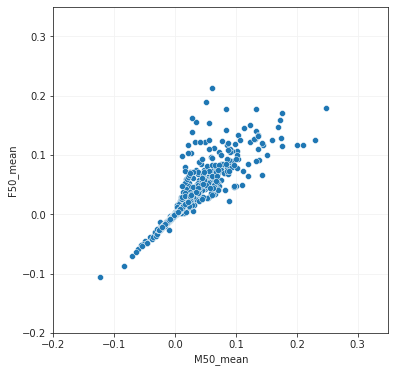

In [44]:
fig = plt.figure(figsize=(6,6))
sns.scatterplot(x="M50_mean", y="F50_mean", data=df_feat_imp_50_FM_train)
plt.ylim(-0.2,0.35)
plt.xlim(-0.2,0.35)

In [45]:
# r² para os snps x sexo

(-0.2, 0.35)

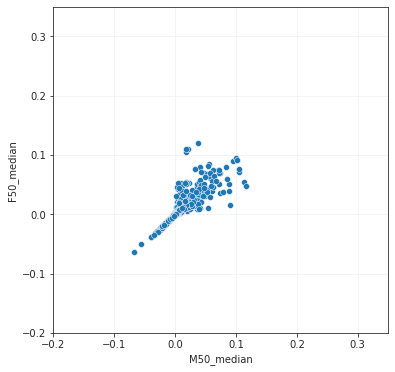

In [46]:
fig = plt.figure(figsize=(6,6))
sns.scatterplot(x="M50_median", y="F50_median", data=df_feat_imp_50_FM_train)
plt.ylim(-0.2,0.35)
plt.xlim(-0.2,0.35)

In [47]:
df_feat_imp_50_FM_train.sort_values(by="F50_mean").tail(20)

,M50_mean,M50_median,F50_mean,F50_median
snp_4_172986805,0.173504,0.084696,0.129019,0.059755
snp_5_109351989,0.135550,0.101614,0.131583,0.091138
snp_4_174916149,0.136084,0.074243,0.132883,0.070264
snp_13_100003066,0.104003,0.057180,0.133997,0.069961
snp_19_32504936,0.027856,0.005112,0.138147,0.042420
snp_9_27901523,0.133152,0.057747,0.139878,0.061462
snp_19_23093093,0.083327,0.038023,0.142940,0.119658
snp_7_156787327,0.113298,0.052266,0.145462,0.068079
snp_20_32074430,0.168519,0.100658,0.147949,0.094929
snp_13_100042644,0.123461,0.062261,0.149794,0.074323


In [48]:
df_feat_imp_50_FM_train.to_csv("feat_importance_trainset_FM50_lc7-2021-10-05.csv")

In [49]:
# tmp = feat_imp_M50.join(feat_imp_F50, how='inner')
df_feat_imp_50_FM_train_selection = df_feat_imp_50_FM_train[abs((df_feat_imp_50_FM_train['M50_mean']+df_feat_imp_50_FM_train['F50_mean']))/2 > 0.05]
df_feat_imp_50_FM_train_selection['SNP'] = df_feat_imp_50_FM_train_selection.index
# parallel_coordinates(tmp, '1_M50', cols='M50_mean','F50_mean'])
df_feat_imp_50_FM_train_selection.sort_values(by="M50_mean")

<ipython-input-49-b3cbf51b0057>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_feat_imp_50_FM_train_selection['SNP'] = df_feat_imp_50_FM_train_selection.index


,M50_mean,M50_median,F50_mean,F50_median,SNP
snp_17_15464147,-0.122788,-0.068198,-0.106112,-0.063339,snp_17_15464147
snp_21_11058226,-0.083686,-0.056430,-0.087411,-0.050819,snp_21_11058226
snp_11_89308032,-0.071195,-0.039684,-0.070252,-0.037654,snp_11_89308032
snp_11_89308027,-0.063839,-0.030156,-0.063528,-0.029488,snp_11_89308027
snp_16_82889990,-0.060559,-0.040303,-0.059326,-0.038795,snp_16_82889990
...,...,...,...,...,...
snp_9_140296542,0.176414,0.089314,0.114787,0.039742,snp_9_140296542
snp_4_138909352,0.200439,0.113484,0.116085,0.054696,snp_4_138909352
snp_19_34109339,0.210778,0.116638,0.116106,0.048115,snp_19_34109339
snp_17_15868329,0.229710,0.071392,0.125517,0.051322,snp_17_15868329


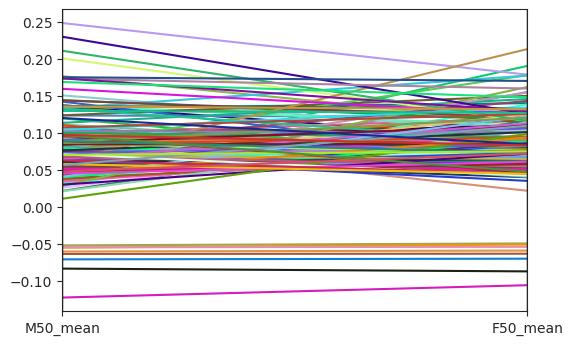

In [50]:
fig = plt.figure(dpi=100)
parallel_coordinates(df_feat_imp_50_FM_train_selection, 'SNP', cols=['M50_mean', 'F50_mean'] ).legend().remove() 

In [51]:
#j

# SNP Importance - Lifelong variability

In [52]:
df_feat_imp_by_age_train = feat_importance(e_train, 20, 'X') 
for age in range(30, 90, 10):
    df_feat_imp_by_age_train = df_feat_imp_by_age_train.join(feat_importance(e_train, age, 'X'),how='inner')

In [53]:
mask = np.array([(abs(df_feat_imp_by_age_train[f'X{age}_mean']) > 2*df_feat_imp_by_age_train[f'X{age}_mean'].std()).values for age in [20,30,40,50,60,70,80]])
count = np.sum(mask, axis=1)
# mask = np.sum(mask, axis=0).astype(bool)

In [54]:
mask = np.sum(mask, axis=0)

In [55]:
mask = mask > 2

In [56]:
# 164 snps with feat_importante > 2*std in at least one age
mask.sum()

105

<ipython-input-57-12501105aaae>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_feat_imp_by_age_train_selection['SNP'] = df_feat_imp_by_age_train_selection.index


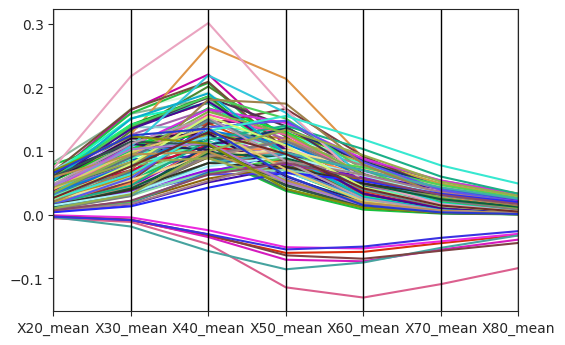

In [57]:
# mean

df_feat_imp_by_age_train_selection = df_feat_imp_by_age_train[mask]
df_feat_imp_by_age_train_selection['SNP'] = df_feat_imp_by_age_train_selection.index
fig = plt.figure(dpi=100)
parallel_coordinates(df_feat_imp_by_age_train_selection, 'SNP', cols=[i for i in df_feat_imp_by_age_train.columns if 'mean' in i]).legend().remove() 

In [58]:
df_feat_imp_by_age_train_selection.sort_values(by="X50_mean").head(10)

,X20_mean,X20_median,X30_mean,X30_median,X40_mean,X40_median,X50_mean,X50_median,X60_mean,X60_median,X70_mean,X70_median,X80_mean,X80_median,SNP
snp_17_15464147,-0.005558,-2.917365e-08,-0.011194,-0.000152,-0.046048,-0.014813,-0.113946,-0.065501,-0.129971,-0.076612,-0.108910,-0.058273,-0.083711,-0.037872,snp_17_15464147
snp_21_11058226,-0.003628,-3.148472e-08,-0.018409,-0.000259,-0.056970,-0.019454,-0.085580,-0.053485,-0.074926,-0.040795,-0.051893,-0.016907,-0.032412,-0.005612,snp_21_11058226
snp_11_89308032,-0.002305,-3.547148e-08,-0.007752,-0.000126,-0.034998,-0.007443,-0.070583,-0.038380,-0.073084,-0.038476,-0.054694,-0.019161,-0.038959,-0.008197,snp_11_89308032
snp_11_89308027,-0.002602,-3.785187e-08,-0.007825,-0.000102,-0.030952,-0.006323,-0.063661,-0.029908,-0.068993,-0.034655,-0.056500,-0.020019,-0.044233,-0.010108,snp_11_89308027
snp_16_82889990,-0.003041,-2.215835e-08,-0.008697,-0.000132,-0.033212,-0.010543,-0.059832,-0.039546,-0.058195,-0.038018,-0.044530,-0.020339,-0.032161,-0.008615,snp_16_82889990
snp_13_112290416,-0.003014,-2.720269e-08,-0.008400,-0.000136,-0.030562,-0.010614,-0.054410,-0.035011,-0.049915,-0.031252,-0.036175,-0.017176,-0.025689,-0.006809,snp_13_112290416
snp_11_363705,-0.000813,-7.314366e-09,-0.004082,-0.000059,-0.024264,-0.007425,-0.050949,-0.031898,-0.052856,-0.036371,-0.041703,-0.023244,-0.029913,-0.010215,snp_11_363705
snp_4_189363499,0.079032,1.298066e-02,0.120834,0.038171,0.092962,0.035489,0.037542,0.008398,0.008155,0.001312,0.001908,0.000307,0.000625,0.000116,snp_4_189363499
snp_10_108808535,0.058734,2.106628e-02,0.103169,0.049612,0.095765,0.040196,0.039745,0.013001,0.011615,0.001849,0.002892,0.000419,0.000866,0.000156,snp_10_108808535
snp_5_127750603,0.069107,6.881949e-03,0.123300,0.036895,0.111461,0.036682,0.040782,0.013840,0.011196,0.002093,0.003033,0.000525,0.000993,0.000195,snp_5_127750603


In [59]:
snp_annot = pd.read_csv('../data/SNP_ANNOTATION.csv')

In [60]:
snp_annot.columns

Index(['id', 'X50_mean', 'X50_median', 'chr', 'pos', 'Ref', 'Alt', 'Name',
       'Func.refGene', 'Gene.refGene', 'GeneDetail.refGene',
       'ExonicFunc.refGene', 'AAChange.refGene', 'Func.knownGene',
       'Gene.knownGene', 'GeneDetail.knownGene', 'ExonicFunc.knownGene',
       'AAChange.knownGene', 'snp138', 'avsnp144', 'SIFT_score', 'SIFT_pred',
       'Polyphen2_HDIV_score', 'Polyphen2_HDIV_pred', 'Polyphen2_HVAR_score',
       'Polyphen2_HVAR_pred', 'LRT_score', 'LRT_pred', 'MutationTaster_score',
       'MutationTaster_pred', 'MutationAssessor_score',
       'MutationAssessor_pred', 'FATHMM_score', 'FATHMM_pred', 'PROVEAN_score',
       'PROVEAN_pred', 'VEST3_score', 'CADD_raw', 'CADD_phred', 'DANN_score',
       'fathmm-MKL_coding_score', 'fathmm-MKL_coding_pred', 'MetaSVM_score',
       'MetaSVM_pred', 'MetaLR_score', 'MetaLR_pred',
       'integrated_fitCons_score', 'integrated_confidence_value', 'GERP++_RS',
       'phyloP7way_vertebrate', 'phyloP20way_mammalian',
       '

In [61]:
snp_annot[['id', 'Func.knownGene', 'Gene.refGene', 'GeneDetail.refGene', 'avsnp144']]

,id,Func.knownGene,Gene.refGene,GeneDetail.refGene,avsnp144
0,snp_16_19717582,downstream,KNOP1,.,rs142650764
1,snp_17_15464147,.,TVP23C,TVP23C-CDRT4,.
2,snp_8_80259779,.,IL7,STMN2,.
3,snp_10_61094304,intronic,FAM13C,.,rs7905758
4,snp_8_9167827,.,LOC101929128,LOC157273,.
...,...,...,...,...,...
151,snp_14_36490375,.,BRMS1L,LINC00609,.
152,snp_11_120855337,intronic,GRIK4,.,rs142031364
153,snp_19_45860157,intronic,ERCC2,.,rs188284016
154,snp_10_15653813,intronic,ITGA8,.,rs374820904


In [62]:
df_annot = df_feat_imp_by_age_train_selection.join(snp_annot[['id', 'Func.knownGene', 'Gene.refGene', 'GeneDetail.refGene', 'avsnp144']].set_index('id'))

In [63]:
df_annot.fillna('na', inplace=True)

In [64]:
[f"{snp[0].ljust(16)}|{snp[1].ljust(15)}|{snp[2].ljust(13)}|{snp[3].ljust(13)}|{snp[4].ljust(11)}|" for snp in df_annot[['SNP', 'Func.knownGene', 'Gene.refGene', 'GeneDetail.refGene', 'avsnp144']].values]

['snp_18_56742728 |.              |OACYLP       |SEC11C       |.          |',
 'snp_6_78992097  |.              |MEI4         |IRAK1BP1     |.          |',
 'snp_9_140296542 |intronic       |EXD3         |.            |.          |',
 'snp_11_110920906|na             |na           |na           |na         |',
 'snp_3_33980894  |na             |na           |na           |na         |',
 'snp_19_45860157 |intronic       |ERCC2        |.            |rs188284016|',
 'snp_19_19365233 |.              |NCAN         |HAPLN4       |.          |',
 'snp_9_27901523  |.              |C9orf72      |LINGO2       |.          |',
 'snp_1_209147965 |.              |PLXNA2       |MIR205HG     |.          |',
 'snp_4_95889514  |intronic       |BMPR1B       |.            |rs573809287|',
 'snp_3_75343128  |.              |MIR4444-1    |FAM86DP      |.          |',
 'snp_4_172578583 |.              |MIR6082      |GALNTL6      |.          |',
 'snp_3_74931582  |.              |CNTN3        |MIR4444-1    |.

In [65]:
[" | ".join([f.ljust(18) for f in snp]) for snp in df_annot[['SNP', 'Func.knownGene', 'Gene.refGene', 'GeneDetail.refGene', 'avsnp144']].values]

['snp_18_56742728    | .                  | OACYLP             | SEC11C             | .                 ',
 'snp_6_78992097     | .                  | MEI4               | IRAK1BP1           | .                 ',
 'snp_9_140296542    | intronic           | EXD3               | .                  | .                 ',
 'snp_11_110920906   | na                 | na                 | na                 | na                ',
 'snp_3_33980894     | na                 | na                 | na                 | na                ',
 'snp_19_45860157    | intronic           | ERCC2              | .                  | rs188284016       ',
 'snp_19_19365233    | .                  | NCAN               | HAPLN4             | .                 ',
 'snp_9_27901523     | .                  | C9orf72            | LINGO2             | .                 ',
 'snp_1_209147965    | .                  | PLXNA2             | MIR205HG           | .                 ',
 'snp_4_95889514     | intronic      

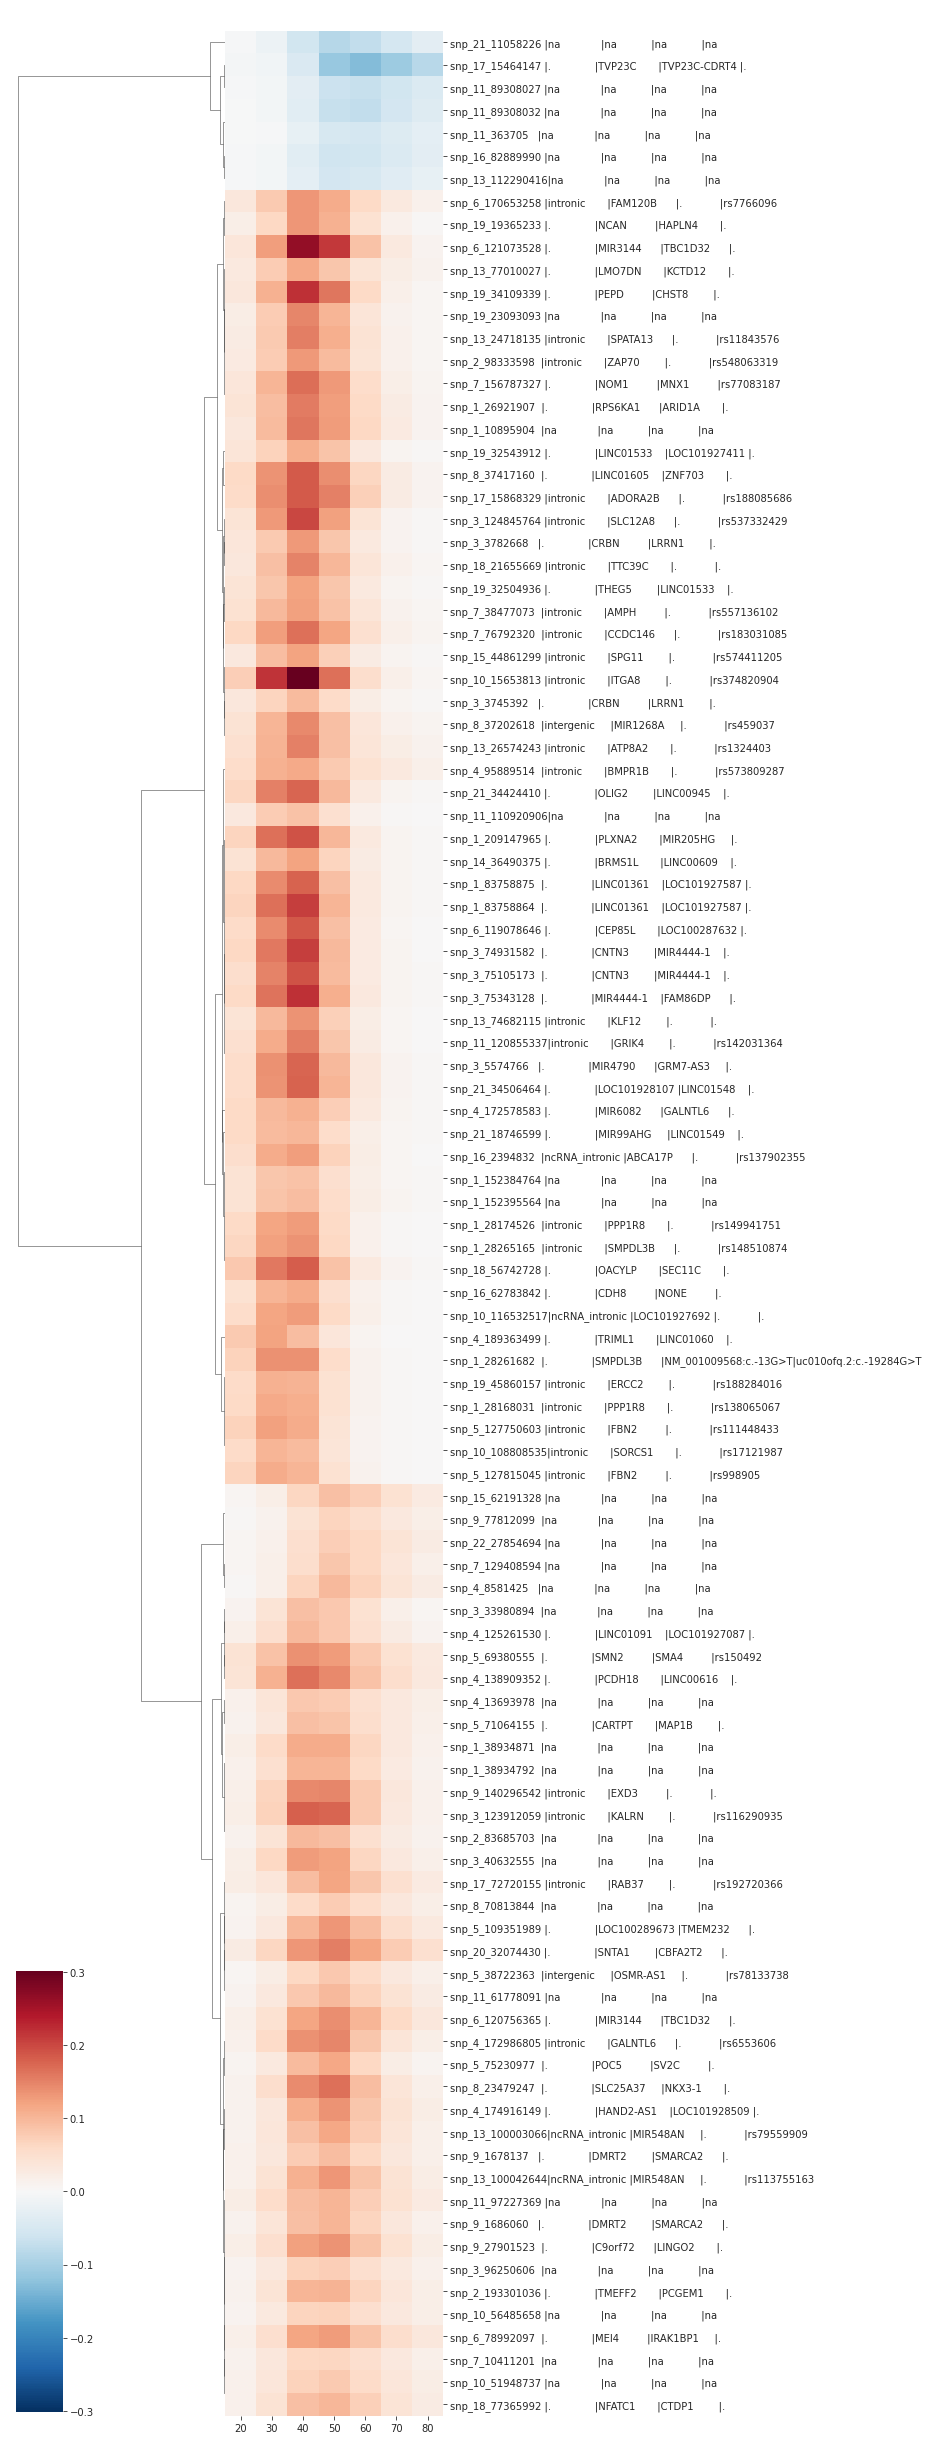

In [66]:
def plot_mat(df):
    c = [c for c in df.columns if 'mean' in c]
    abs_max = np.max(np.abs(df[c].values))
#     labels = [snp.split('_')) for snp in df.index]
#     plt.matshow(v, cmap="RdBu_r")
    g = sns.clustermap(
    #     data[data.columns[~data.columns.isin(['AGE','sex','mo_t2d','fa_t2d'])]].astype(float),
        df[c],# Ignore non-snp data
    #     cmap='coolwarm',
        cmap="RdBu_r",
        vmin=-abs_max, 
        vmax=abs_max,
        dendrogram_ratio=(.5,.01),
        # row_linkage using a distance for snps: dist(0,2) or dist(2,0) = 1 else 0
#         row_linkage=linkage(pdist(X, lambda u, v: (abs(u-v)>1).sum()),method='single'),
        metric="correlation", 
        method="average",
        col_cluster=False,
        figsize=(13,34),
        cbar_pos=(0.021, 0.013, .05, .18),
#         row_colors=[[0.5,1-float(snp.split('_')[1])/22, 1-float(snp.split('_')[1])/22] for snp in df.index],
    #     palette=colors,
        yticklabels=[f"{snp[0].ljust(16)}|{snp[1].ljust(15)}|{snp[2].ljust(13)}|{snp[3].ljust(13)}|{snp[4].ljust(11)}" for snp in df[['SNP', 'Func.knownGene', 'Gene.refGene', 'GeneDetail.refGene', 'avsnp144']].values],
        xticklabels=[20,30,40,50,60,70,80], 
    )
#     g.savefig("snp_importance_cluster.pdf")
#     print(v)
# plot_mat(df_feat_imp_by_age_train_selection.sort_values(by="X50_mean"))
plot_mat(df_annot.sort_values(by="X50_mean"))

In [67]:
import matplotlib as mpl
mpl.rcParams['font.family'] = 'monospace'


In [68]:
"hu".ljust(10)

'hu        '

<ipython-input-69-142dff17a441>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_feat_imp_by_age_train_selection['SNP'] = df_feat_imp_by_age_train_selection.index


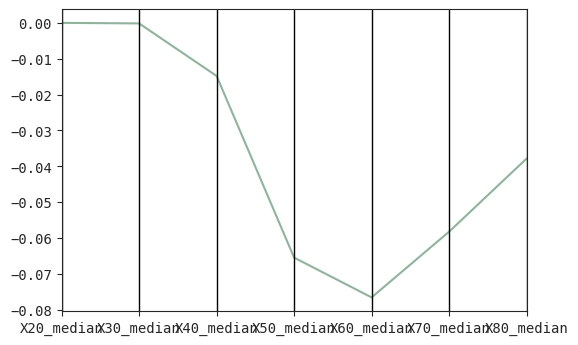

In [69]:
# median
df_feat_imp_by_age_train_selection = df_feat_imp_by_age_train[abs(df_feat_imp_by_age_train['X80_median']) > 0.02]
df_feat_imp_by_age_train_selection['SNP'] = df_feat_imp_by_age_train_selection.index
fig = plt.figure(dpi=100)
parallel_coordinates(df_feat_imp_by_age_train_selection, 'SNP', cols=[i for i in df_feat_imp_by_age_train.columns if 'median' in i]).legend().remove() 

In [70]:
# tmp = feat_imp_M50.join(feat_imp_F50, how='inner')
# tmp = tmp[abs((tmp['M50_mean']+tmp['F50_mean']))/2 > 0.04]
# tmp['SNP'] = tmp.index
# # parallel_coordinates(tmp, '1_M50', cols='M50_mean','F50_mean'])
# tmp.sort_values(by="M50_mean")

In [71]:
# fig = plt.figure(dpi=100)
# parallel_coordinates(tmp, 'SNP', cols=['M50_mean', 'F50_mean'])

In [72]:
# feat_imp_by_age = feat_importance(e_test, 20, 'X') 
# for age in range(30, 90, 10):
#     feat_imp_by_age = feat_imp_by_age.join(feat_importance(e_test, age, 'X'),how='inner')
    

In [73]:
# [i for i in feat_imp_by_age.columns if 'mean' in i]

In [74]:
# tmp = feat_imp_by_age[abs(feat_imp_by_age['X80_mean']) > 0.04]
# tmp['SNP'] = tmp.index
# parallel_coordinates(tmp, 'SNP', cols=[i for i in feat_imp_by_age.columns if 'mean' in i])

<AxesSubplot:>

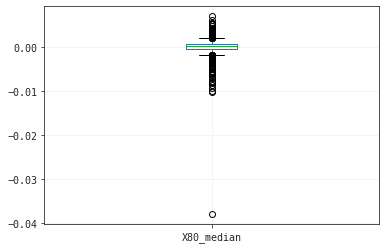

In [75]:
df_feat_imp_by_age_train[['X80_median']].boxplot()

In [76]:
feat_imp_M50.sort_values(by=0, ascending=False).head(50)

NameError: name 'feat_imp_M50' is not defined

In [ ]:
imp = e_test.calc_attr(20, 'X', samples_per_model=1)

In [ ]:
s

In [ ]:
dfnew.sort_values(by=0, ascending=True).head(50)

In [ ]:
import pandas as pd
dfnew = pd.DataFrame.from_dict(s, orient='index')
dfnew.sort_values(by=0, ascending=False).head(50)

In [ ]:
import pandas as pd
dfnew = pd.DataFrame.from_dict(s, orient='index')
dfnew.sort_values(by=0, ascending=False).head(50)

In [ ]:
import pandas as pd
df = pd.DataFrame.from_dict(s, orient='index')

In [ ]:
df.sort_values(by=0, ascending=True).head(50)

In [ ]:
df.sort_values(by=0, ascending=True).head(50)

In [ ]:
import numpy as np
np.mean(df.values, axis=0)

In [ ]:
df_20_X = e_train.attr_snps_mean(attrs, mask).rename(columns={0: "age=20,sex=X"})

In [ ]:
df_20_X.sort_values(by="age=20,sex=X", ascending=False).head(50)

In [ ]:
attr, mask = e_train.calc_attr(20, 'X', samples=1)
df_20_X = e_train.attr_snps_mean(attr, mask).rename(columns={0: "age=20,sex=X"})
attr, mask = e_train.calc_attr(20, 'M', samples=1)
df_20_M = e_train.attr_snps_mean(attr, mask).rename(columns={0: "age=20,sex=M"})
attr, mask = e_train.calc_attr(20, 'F', samples=1)
df_20_F = e_train.attr_snps_mean(attr, mask).rename(columns={0: "age=20,sex=F"})

In [ ]:
df_decay2 = df_20_X.sort_values(by="age=20,sex=X", ascending=False)
df_decay2.head(20)

In [ ]:
df_decay1 = df_20_X.sort_values(by="age=20,sex=X", ascending=False)
df_decay1.head(20)

In [ ]:
df_train[df_train.index=='snp_4_172986805']

In [ ]:
attr, mask = e_train.calc_attr(50, 'X', samples=1)
df_50_X = e_train.attr_snps_mean(attr, mask).rename(columns={0: "age=50,sex=X"})
attr, mask = e_train.calc_attr(50, 'M', samples=1)
df_50_M = e_train.attr_snps_mean(attr, mask).rename(columns={0: "age=50,sex=M"})
attr, mask = e_train.calc_attr(50, 'F', samples=1)
df_50_F = e_train.attr_snps_mean(attr, mask).rename(columns={0: "age=50,sex=F"})

In [ ]:
df_train = df_20_X.join([df_20_F,df_20_M,df_50_X,df_50_F,df_50_M])

In [ ]:
df_train.sort_values(by="age=20,sex=X", ascending=False).head(50)

In [ ]:
df_train.sort_values(by="age=50,sex=X", ascending=False).tail(50)

In [ ]:
plt.boxplot(df_20_X.values)

In [ ]:
attr, mask = e_test.calc_attr(20, 'X', samples=1)
df_20_X_test = e_test.attr_snps_mean(attr, mask).rename(columns={0: "age=20,sex=X"})
attr, mask = e_test.calc_attr(20, 'M', samples=1)
df_20_M_test = e_test.attr_snps_mean(attr, mask).rename(columns={0: "age=20,sex=M"})
attr, mask = e_test.calc_attr(20, 'F', samples=1)
df_20_F_test = e_test.attr_snps_mean(attr, mask).rename(columns={0: "age=20,sex=F"})

In [ ]:
attr, mask = e_test.calc_attr(50, 'X', samples=1)
df_50_X_test = e_test.attr_snps_mean(attr, mask).rename(columns={0: "age=50,sex=X"})
attr, mask = e_test.calc_attr(50, 'M', samples=1)
df_50_M_test = e_test.attr_snps_mean(attr, mask).rename(columns={0: "age=50,sex=M"})
attr, mask = e_test.calc_attr(50, 'F', samples=1)
df_50_F_test = e_test.attr_snps_mean(attr, mask).rename(columns={0: "age=50,sex=F"})

In [ ]:
df_test = df_20_X_test.join([df_20_F_test,df_20_M_test,df_50_X_test,df_50_F_test,df_50_M_test])

In [ ]:
df_test.sort_values(by="age=20,sex=X", ascending=False).head(50)

In [ ]:
df_test.sort_values(by="age=20,sex=X", ascending=False).tail(50)

In [ ]:
df = df_train.join(df_test, lsuffix='_train', rsuffix='_test')

In [ ]:
sns.pairplot(df.sort_values(by="age=20,sex=X_train", ascending=False).head(20))
# plt.savefig('pairplot.svg')

In [ ]:
df.sort_values(by="age=20,sex=X_train", ascending=False).head(20)

In [ ]:
df_sel = df.reindex(df["age=20,sex=X_train"].abs().sort_values(ascending=False).index).head(100)

In [ ]:
df_sel

In [ ]:
tmp = dict(Counter([s[:s.index('_',4)] for s in list(df_sel.index)]))
sns.barplot(x=list(tmp.keys()), y=list(tmp.values()))

In [ ]:
df_not_sel = df.reindex(df["age=20,sex=X_train"].abs().sort_values(ascending=False).index).tail(500)

In [ ]:
Counter([s[:s.index('_',4)] for s in list(df_not_sel.index)])

In [ ]:
list(tmp.values())

In [ ]:
plt.subplot(141)
plt.title("Precision")
plt.barh(y=list(tmp.keys()),width=list(tmp.values()))
# plt.xlim(0,1)
plt.subplot(142)
plt.title("Recall")
plt.barh(y=list(tmp.keys()),width=list(tmp.values()))
# plt.xlim(0,1)
plt.yticks([])
plt.subplot(143)
plt.title("F1-Score")
plt.barh(y=list(tmp.keys()),width=list(tmp.values()))
# plt.xlim(0,1)
plt.yticks([])
plt.subplot(144)
plt.title("Frequency")
plt.barh(y=list(tmp.keys()),width=list(tmp.values()))
plt.xscale('log')
plt.yticks([])

In [ ]:
feat_imp_M50.sort_values(by='M50_mean')

In [ ]:
feat_imp_M50.sort_values(by='M50_mean')

In [ ]:
plt.boxplot(feat_imp_M50['M50_mean'])

In [ ]:
df_test = pd.read_csv("../datasets/visits_sp_unique_test_positivo_1000_random_0.csv")

In [ ]:
df_train = pd.read_csv("../datasets/visits_sp_unique_train_positivo_1000_random_0.csv")

In [ ]:
c1 = df_test.columns
c2 = df_train.columns
for i in range(1009):
    if c1[i] != c2[i]:
        print(f"{c1[i]} = {c2[i]}")
    

In [ ]:
a = np.arange(-10,10)

In [ ]:
a

In [ ]:
plt.scatter(x=1,y=a)

In [ ]:
# comparação entre lc[1-7]

In [ ]:
df_tmp_lc1 = pd.read_csv("./feat_importance_trainset_X50_lc5-2021-10-05.csv")

In [ ]:
df_tmp_lc2 = pd.read_csv("./feat_importance_trainset_X50_lc2-2021-10-05.csv")

In [ ]:
sns.scatterplot(df_tmp_lc1['X50_mean'], df_tmp_lc2['X50_mean'])

In [ ]:
from scipy import stats

In [ ]:
stats.pearsonr(df_tmp_lc1['X50_mean'], df_tmp_lc2['X50_mean'])

In [ ]:
df_tmps = [pd.read_csv(f"./feat_importance_trainset_X50_lc{i}-2021-10-05.csv") for i in range(1,8)]
    

In [ ]:
for i in range(len(df_tmps)):
    for j in range(i+1, len(df_tmps)):
        print(i+1,j+1)
        print(stats.pearsonr(df_tmps[i]['X50_mean'], df_tmps[j]['X50_mean']))
        print(stats.pearsonr(df_tmps[i]['X50_median'], df_tmps[j]['X50_median']))

In [ ]:
sns.scatterplot(df_tmps[0]['X50_mean'], df_tmps[6]['X50_mean'])

In [ ]:
df_tmps[6]['X50_mean'].describe()

In [ ]:
df_annot